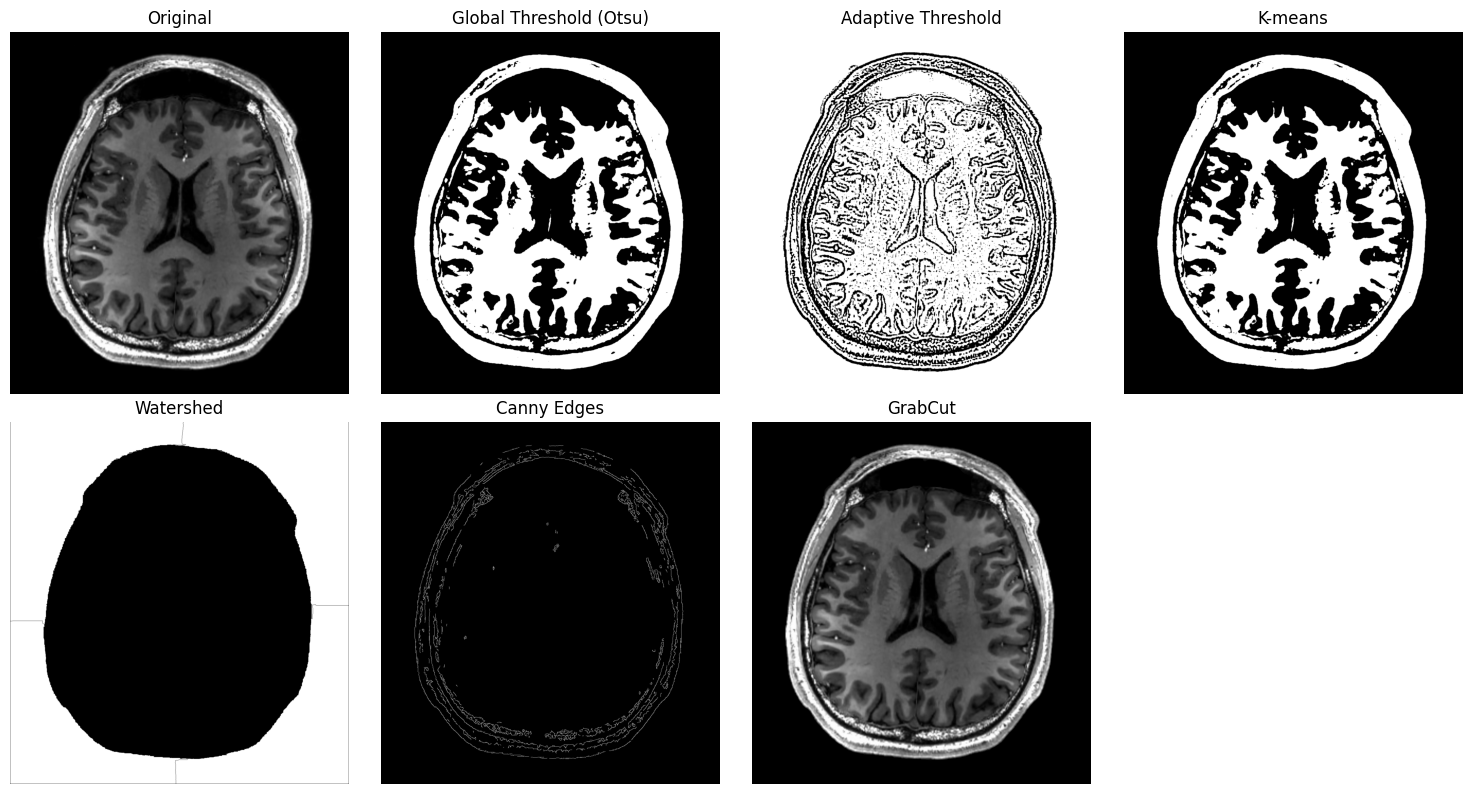

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, segmentation, color
from sklearn.cluster import KMeans

# 1. Load image (grayscale or RGB)
image = cv2.imread('mri.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Prepare segmentations:
results = []

# (a) Global Thresholding (Otsu)
_, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
results.append(('Global Threshold (Otsu)', thresh_otsu))

# (b) Adaptive Thresholding
adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                 cv2.THRESH_BINARY, 11, 2)
results.append(('Adaptive Threshold', adaptive))

# (c) K-means Clustering
Z = image.reshape((-1, 3))
Z = np.float32(Z)
K = 2
criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
kmeans_result = centers[labels.flatten()].reshape(image.shape).astype(np.uint8)
results.append(('K-means', cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2GRAY)))

# (d) Watershed
# Watershed usually works on markers; here's a basic form:
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations=2)
# Sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
_, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(image,markers)
watershed_out = np.zeros_like(gray)
watershed_out[markers > 1] = 255
results.append(('Watershed', watershed_out))

# (e) Edge-based (Canny)
edges = cv2.Canny(gray, 100, 200)
results.append(('Canny Edges', edges))

# (f) GrabCut (Graph Cut, OpenCV)
mask = np.zeros(image.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (10,10,image.shape[1]-20,image.shape[0]-20) # change as needed
cv2.grabCut(image,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
grabcut_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
grabcut_out = image * grabcut_mask[:,:,np.newaxis]
results.append(('GrabCut', cv2.cvtColor(grabcut_out, cv2.COLOR_BGR2GRAY)))

# Optionally: Deep Learning Segmentation (U-Net or pretrained models)
# This step is more involved - needs pre-trained weights & package setup

# 3. Plot results
plt.figure(figsize=(15, 8))
n = len(results) + 1
plt.subplot(2, (n+1)//2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')
for i, (title, res) in enumerate(results):
    plt.subplot(2, (n+1)//2, i+2)
    plt.imshow(res, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


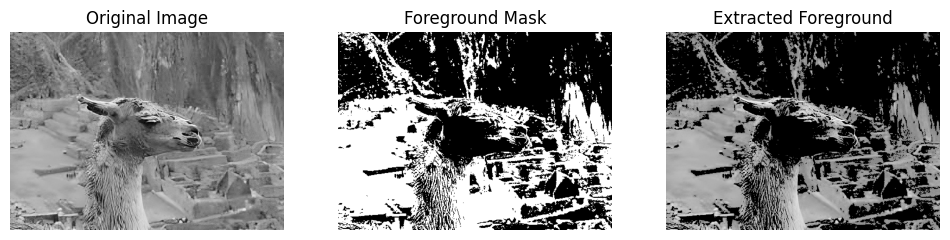

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# --- Load grayscale image ---
image = io.imread('sample.jpeg', as_gray=True)
image = (image * 255).astype(np.uint8)  # convert from float [0,1] to uint8 [0,255]

# --- Otsu's thresholding (from scratch, can use OpenCV/skimage for real applications) ---
def otsu_threshold(img):
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    total = img.size
    sumB = 0.0
    wB = 0
    maximum = 0.0
    sum1 = np.dot(np.arange(256), hist)
    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += float(t * hist[t])
        mB = sumB / wB
        mF = (sum1 - sumB) / wF
        varBetween = wB * wF * (mB - mF) ** 2
        if varBetween > maximum:
            maximum = varBetween
            threshold = t
    return threshold

thresh_val = otsu_threshold(image)
foreground_mask = (image > thresh_val).astype(np.uint8)

# --- Optionally: extract only the foreground pixels from original image ---
foreground = image * foreground_mask

# --- Display results ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(foreground_mask, cmap='gray')
plt.title('Foreground Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(foreground, cmap='gray')
plt.title('Extracted Foreground')
plt.axis('off')
plt.show()


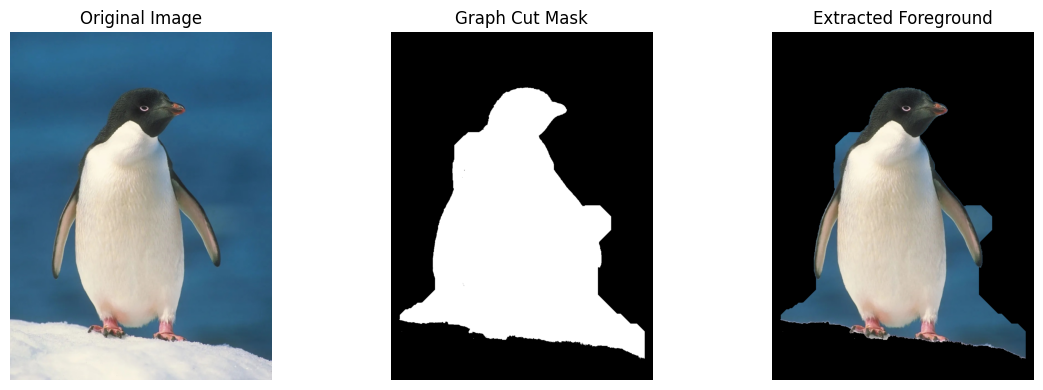

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Load image (color or grayscale) ----
image = cv2.imread('penguin.jpeg')  # Replace with your image path
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---- Create initial mask (0=bg, 1=fg, 2=prob-bg, 3=prob-fg) ----
# For pure binary: Initialize all as "probably background"
mask = np.zeros(image.shape[:2], np.uint8)

# ---- Define a rectangle containing the foreground ----
# Format: (x, y, width, height)
rect = (30, 30, image.shape[1]-60, image.shape[0]-60)  # Try to tightly contain the foreground object

# Temporary arrays used internally by GrabCut
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# ---- Run GrabCut (Graph Cut) ----
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, mode=cv2.GC_INIT_WITH_RECT)

# The resulting mask: 0/2 = bg, 1/3 = fg
binary_mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

# ---- Extract Foreground ----
foreground = rgb * binary_mask[:,:,np.newaxis]

# ---- Show Output ----
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Graph Cut Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(foreground)
plt.title('Extracted Foreground')
plt.axis('off')

plt.tight_layout()
plt.show()


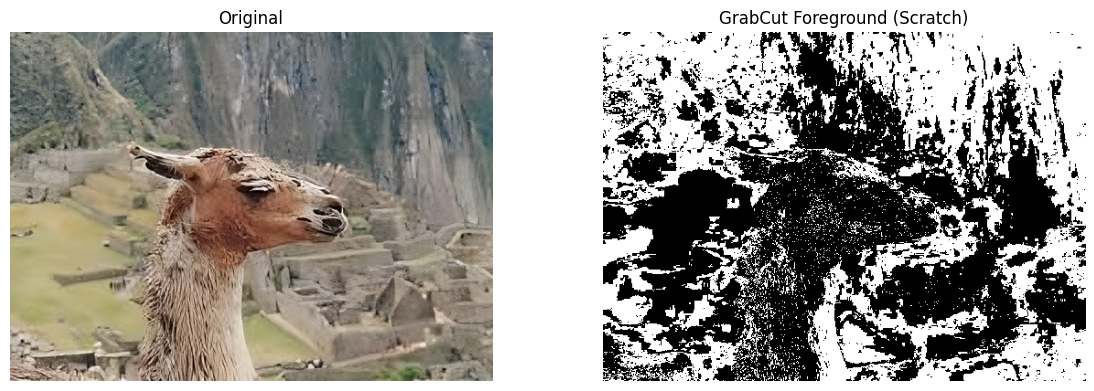

In [13]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import maxflow  # PyMaxflow

def fit_gmm(data, n_components=5):
    gmm = GaussianMixture(n_components, covariance_type='full')
    gmm.fit(data)
    return gmm

# --- Load image ---
image = io.imread('sample.jpeg')
if image.ndim == 2:  # grayscale
    image = np.stack([image]*3, axis=-1)
rgb = image[..., :3]
pixels = rgb.reshape((-1, 3))

# --- Initialize mask (user input box) ---
mask = np.zeros(rgb.shape[:2], dtype=np.uint8)
rect = (30, 30, rgb.shape[1]-60, rgb.shape[0]-60)  # (x, y, w, h), adjust as needed
mask[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = 1  # probable foreground

# --- Fit initial GMM for foreground/background ---
fg_pixels = pixels[mask.flatten() == 1]
bg_pixels = pixels[mask.flatten() == 0]
fg_gmm = fit_gmm(fg_pixels)
bg_gmm = fit_gmm(bg_pixels)

# --- Data terms: negative log-likelihood of pixel from fg/bg GMM ---
fg_ll = -fg_gmm.score_samples(pixels)
bg_ll = -bg_gmm.score_samples(pixels)

beta = 0.1  # smoothness scaler

# --- Compute edge weights (smoothness) between pixel neighbors ---
def compute_smooth_edges(img):
    h, w, _ = img.shape
    edges = []
    for y in range(h):
        for x in range(w):
            idx = y * w + x
            # Right neighbor
            if x < w-1:
                diff = np.linalg.norm(img[y,x] - img[y,x+1])
                weight = np.exp(-beta * diff)
                edges.append((idx, idx+1, weight))
            # Bottom neighbor
            if y < h-1:
                diff = np.linalg.norm(img[y,x] - img[y+1,x])
                weight = np.exp(-beta * diff)
                edges.append((idx, idx+w, weight))
    return edges

edges = compute_smooth_edges(rgb)

# --- Build graph ---
h, w = rgb.shape[:2]
g = maxflow.Graph[float](h*w, len(edges)*2)
nodes = g.add_nodes(h*w)

for idx in range(h*w):
    # Data term (t-links): higher cost to assign pixel to bg if in fg region, and vice versa
    g.add_tedge(idx, bg_ll[idx], fg_ll[idx])

for u, v, weight in edges:
    g.add_edge(u, v, weight, weight)

# --- Min-cut ---
flow = g.maxflow()
labels = np.array([g.get_segment(i) for i in range(h*w)]).reshape((h, w))
# Segment: 0 = bg, 1 = fg

# --- Show result ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(labels, cmap='gray')
plt.title('GrabCut Foreground (Scratch)')
plt.axis('off')
plt.tight_layout()
plt.show()


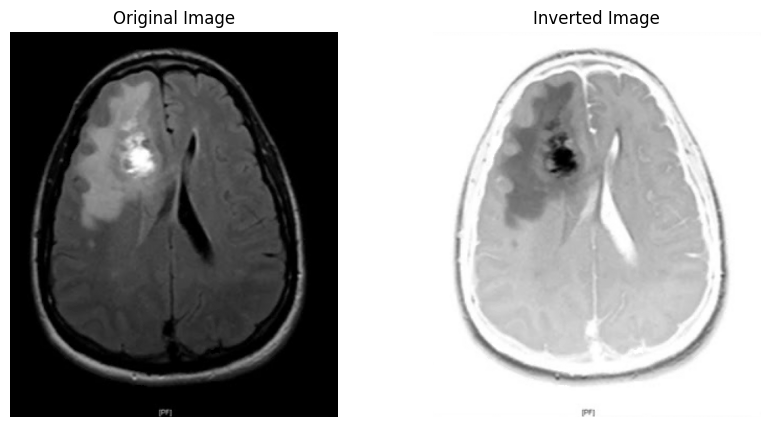

In [21]:
import cv2
import matplotlib.pyplot as plt

# Load image in grayscale
img = cv2.imread('mri.png', cv2.IMREAD_GRAYSCALE)

# Invert colors
img_inverted = 255 - img

# Display original and inverted image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_inverted, cmap='gray')
plt.title('Inverted Image')
plt.axis('off')

plt.show()


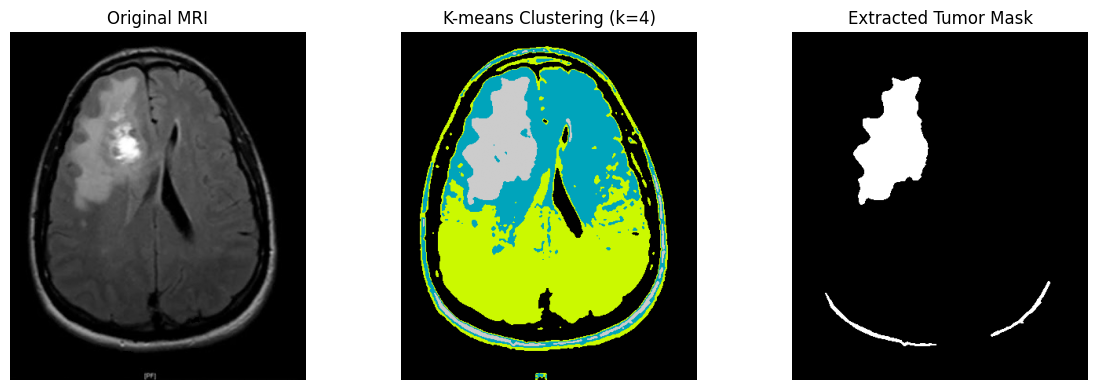

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.ndimage import binary_fill_holes
from sklearn.cluster import KMeans

# 1. Load and preprocess image (grayscale, optional median filter)
img = cv2.imread('mri.png', cv2.IMREAD_GRAYSCALE)
img_med = cv2.medianBlur(img, 3)

# 2. K-means clustering (e.g., k=4 from paper)
pixels = img_med.reshape(-1, 1).astype(np.float32)
k = 4
km = KMeans(n_clusters=k)
km.fit(pixels)
labels = km.labels_.reshape(img_med.shape)

# 3. Find the cluster that likely contains the tumor (brightest, highest mean intensity)
means = [pixels[labels.ravel() == l].mean() for l in range(k)]
tumor_cluster = np.argmax(means)  # usually tumor is brightest

tumor_mask = (labels == tumor_cluster)

# 4. Morphological filtering (disk shape)
tumor_mask = morphology.remove_small_objects(tumor_mask, min_size=150)
tumor_mask = morphology.binary_closing(tumor_mask, morphology.disk(4))
tumor_mask = binary_fill_holes(tumor_mask)

# 5. Visualize results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original MRI')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('K-means Clustering (k=4)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(tumor_mask, cmap='gray')
plt.title('Extracted Tumor Mask')
plt.axis('off')
plt.tight_layout()
plt.show()


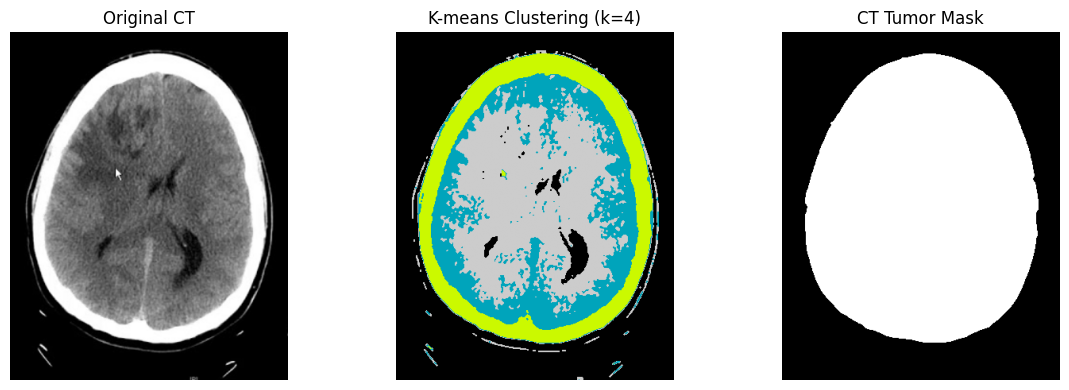

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.ndimage import binary_fill_holes
from sklearn.cluster import KMeans

# 1. Load and preprocess CT image (grayscale, median filter for noise reduction)
ct_img = cv2.imread('ct.png', cv2.IMREAD_GRAYSCALE)
ct_med = cv2.medianBlur(ct_img, 3)

# 2. K-means clustering (e.g., k=4)
pixels = ct_med.reshape(-1, 1).astype(np.float32)
k = 4
km = KMeans(n_clusters=k, random_state=42)
km.fit(pixels)
labels = km.labels_.reshape(ct_med.shape)

# 3. Tumor extraction: typically, the cluster with lowest mean intensity (darkest) or highest (brightest)
means = [pixels[labels.ravel() == l].mean() for l in range(k)]
tumor_cluster = np.argmax(means)  # Use np.argmin(means) if tumor is dark

tumor_mask = (labels == tumor_cluster)

# 4. Morphological operations (cleanup with disk structuring element)
tumor_mask = morphology.remove_small_objects(tumor_mask, min_size=150)
tumor_mask = morphology.binary_closing(tumor_mask, morphology.disk(4))
tumor_mask = binary_fill_holes(tumor_mask)

# 5. Visualize results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(ct_img, cmap='gray')
plt.title('Original CT')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('K-means Clustering (k=4)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(tumor_mask, cmap='gray')
plt.title('CT Tumor Mask')
plt.axis('off')
plt.tight_layout()
plt.show()
